In [1]:
import logging
from tqdm import tqdm
from utils.process_data import get_model_generate
from data_loader.base_loader import BaseLoader
# from data_processor.base_processor import BaseProcessor
from data_loader.cot_loader import CotLoader
from utils.load_config import load_config
import argparse
from utils.load_model import load_model_tokenizer
import data_loader
# import data_processor
from utils.meter import AverageMeter
from utils.process_data import *
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/root/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# total_entropy_token = AverageMeter()
def process_data_token_level(model_generate):
    # logging.info(f"{self.name} process data")
    res_entropy = model_generate['entropy']
    # num_input_tokens = res_entropy[0].__len__()
    # num_heads = res_entropy.shape[0]
    mean_entropy = res_entropy[:,1:].mean()
    # total_entropy_token.update(mean_entropy)
    return mean_entropy.item()

In [3]:
# total_entropy = AverageMeter()
def process_data_sen_level(model, tokenizer,data, model_generate,split_words=None):
    # logging.info(f"{self.name} process data")
    res = model_generate['generate']
    input_ids = model_generate['input_ids']
    encoder = get_encoder_k(model,-1)

    # 划分输入        
    if split_words:
        split_tokens = split_sentence(tokenizer=tokenizer,question=data,input_ids=input_ids,split_words=split_words)
    else:
        split_tokens = split_sentence(tokenizer=tokenizer,question=data,input_ids=input_ids)
        
    # 根据句子切分attention矩阵 weight权重，token_ids 权重对应token下标
    weights,token_ids = split_attn_matrix(model,res,split_tokens,soft_max=True)
    
    # 加权计算embedding得到hidden_states
    hidden_states = weighted_hidden_states(weights,token_ids,res)        

    # 计算attention矩阵
    attn_matrix = get_attention_matrix(encoder,hidden_states).squeeze(0).to(torch.float32)
    
    # 计算entropy
    with torch.no_grad():
        sentence_entropy = get_attention_entropy(attn_matrix.cpu())
        mean_sentence_entropy = torch.mean(sentence_entropy,dim=0).squeeze()
    return mean_sentence_entropy.tolist()

In [4]:
import re

def replace_with_dots(text):
    # 使用正则表达式找到 A: 和 The answer is 之间的部分
    pattern = re.compile(r'(?<=A: ).*?(?=The answer is)', re.DOTALL)
    matches = pattern.findall(text)
    
    # 对每个匹配部分进行替换
    for match in matches:
        # 计算单词和标点符号的总数
        word_count = len(re.findall(r'\w+|[^\w\s]', match))
        # 用等数量的点替换
        replacement = '.' * word_count
        text = text.replace(match, replacement)
    
    return text

In [15]:
class Pipeline:
    def __init__(self, model, tokenizer, model_config, data_loaders:list[BaseLoader]):
        logging.info("Init Pipeline")
        self.model = model
        self.tokenizer = tokenizer 
        self.model_config = model_config
        self.data_loaders = data_loaders
        # self.data_processors = data_processors
        self.min_input_token = 100
        self.max_input_token = 2000
        self.max_sample = 21

    def run(self):
        logging.info("Pipeline start")
        # data_loaders
        for data_loader in self.data_loaders:
            logging.info(f"Data loader {data_loader.name}")
            load_data = data_loader.load_data()
            split_words = data_loader.split_words()
            # init processor
            # for data_processor in self.data_processors:
            #     data_processor.set(data_loader.name)
            index = 0
            nocot_list = []
            dotcot_list = []
            cot_list = []
            # data samples
            for data in load_data:
                if (index+1)%3==2:
                    data = replace_with_dots(data)
                inputs = self.tokenizer(data, padding=False, return_tensors='pt')
                num_input_token = inputs['input_ids'].shape[1]
                # if num_input_token < self.min_input_token or num_input_token > self.max_input_token:
                #     logging.info(f"num_input_token {num_input_token} less than min_input_token {self.min_input_token} or greater than max_input_token {self.max_input_token}")
                #     continue
                # pre process
                model_generate = get_model_generate(self.tokenizer,self.model,data,max_new_tokens=1,max_input_token=400,split_words=split_words)
                index += 1

                total_entropy = process_data_token_level(model_generate)
                if (index)%3==1:
                    nocot_list.append(total_entropy)
                    print(f"{index // 3+1} total_entropy for nocot:",total_entropy)
                elif (index)%3==2:
                    dotcot_list.append(total_entropy)
                    print(f"{index // 3+1} total_entropy for dotcot:",total_entropy)
                else:
                    cot_list.append(total_entropy)
                    print(f"{index // 3} total_entropy for cot:",total_entropy)                                       
                # process_data_sen_level(self.model,self.tokenizer,data,model_generate,split_words=split_words)

                if index >= self.max_sample:
                    break
            # 绘制散点图
            plt.figure(figsize=(10, 6))

            plt.scatter(list(range(len(nocot_list))), nocot_list, color='r', label='nocot')
            plt.scatter(list(range(len(nocot_list))), dotcot_list, color='g', label='dotcot')
            plt.scatter(list(range(len(nocot_list))), cot_list, color='b', label='cot')
            plt.xlabel('Index Example')  # 固定的横坐标
            plt.ylabel('Total Entropy')
            plt.title(f'Total Entropy Scatter of {self.model_config[0]}')
            plt.legend()  # 添加图例
            plt.savefig(f'debug_vis/{self.model_config[0]}_total_entropy.png')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model_name: qwen_0.5b
1 total_entropy for nocot: 0.44916367530822754
1 total_entropy for dotcot: 0.44328856468200684
1 total_entropy for cot: 0.45304355025291443
2 total_entropy for nocot: 0.4494899809360504
2 total_entropy for dotcot: 0.44860586524009705
2 total_entropy for cot: 0.46007129549980164
3 total_entropy for nocot: 0.45057234168052673
3 total_entropy for dotcot: 0.44628381729125977
3 total_entropy for cot: 0.4528801441192627
4 total_entropy for nocot: 0.4327157139778137
4 total_entropy for dotcot: 0.4343469738960266
4 total_entropy for cot: 0.44774091243743896
5 total_entropy for nocot: 0.4385237991809845
5 total_entropy for dotcot: 0.437037855386734
5 total_entropy for cot: 0.4477648138999939
6 total_entropy for nocot: 0.4474088251590729
6 total_entropy for dotcot: 0.44653379917144775
6 total_entropy for cot: 0.4516327679157257
7 total_entropy for nocot: 0.45687127113342285
7 total_entropy for dotcot: 0.45785462856292725
7 total_entropy for cot: 0.46374210715293884


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model_name: qwen_chat_0.5b
1 total_entropy for nocot: 0.5015324950218201
1 total_entropy for dotcot: 0.49345681071281433
1 total_entropy for cot: 0.5206952691078186
2 total_entropy for nocot: 0.5062883496284485
2 total_entropy for dotcot: 0.4983883202075958
2 total_entropy for cot: 0.5219234228134155
3 total_entropy for nocot: 0.5050851702690125
3 total_entropy for dotcot: 0.49875351786613464
3 total_entropy for cot: 0.5103446245193481
4 total_entropy for nocot: 0.508787214756012
4 total_entropy for dotcot: 0.5025323033332825
4 total_entropy for cot: 0.5237313508987427
5 total_entropy for nocot: 0.5114774107933044
5 total_entropy for dotcot: 0.505136251449585
5 total_entropy for cot: 0.5218154191970825
6 total_entropy for nocot: 0.5176141262054443
6 total_entropy for dotcot: 0.5105358958244324
6 total_entropy for cot: 0.5235581398010254
7 total_entropy for nocot: 0.5038356781005859
7 total_entropy for dotcot: 0.5010160803794861
7 total_entropy for cot: 0.5194432735443115


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model_name: qwen_1.8b
1 total_entropy for nocot: 0.39221078157424927
1 total_entropy for dotcot: 0.3889164924621582
1 total_entropy for cot: 0.3948315382003784
2 total_entropy for nocot: 0.3872942626476288
2 total_entropy for dotcot: 0.3867742121219635
2 total_entropy for cot: 0.3926246166229248
3 total_entropy for nocot: 0.374507337808609
3 total_entropy for dotcot: 0.3733845353126526
3 total_entropy for cot: 0.3896627724170685
4 total_entropy for nocot: 0.3797258734703064
4 total_entropy for dotcot: 0.3805295526981354
4 total_entropy for cot: 0.3960888087749481
5 total_entropy for nocot: 0.38882702589035034
5 total_entropy for dotcot: 0.38722407817840576
5 total_entropy for cot: 0.39916566014289856
6 total_entropy for nocot: 0.3952237367630005
6 total_entropy for dotcot: 0.39712509512901306
6 total_entropy for cot: 0.40624886751174927
7 total_entropy for nocot: 0.3833029568195343
7 total_entropy for dotcot: 0.38816818594932556
7 total_entropy for cot: 0.3913097679615021
model_name: q

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1 total_entropy for nocot: 0.46561381220817566
1 total_entropy for dotcot: 0.4627290964126587
1 total_entropy for cot: 0.4672941565513611
2 total_entropy for nocot: 0.46149787306785583
2 total_entropy for dotcot: 0.45713531970977783
2 total_entropy for cot: 0.4699353277683258
3 total_entropy for nocot: 0.45184326171875
3 total_entropy for dotcot: 0.44711023569107056
3 total_entropy for cot: 0.46484386920928955
4 total_entropy for nocot: 0.45672333240509033
4 total_entropy for dotcot: 0.45279407501220703
4 total_entropy for cot: 0.4744057357311249
5 total_entropy for nocot: 0.46663159132003784
5 total_entropy for dotcot: 0.4597059190273285
5 total_entropy for cot: 0.47569918632507324
6 total_entropy for nocot: 0.46921753883361816
6 total_entropy for dotcot: 0.4664265811443329
6 total_entropy for cot: 0.47659623622894287
7 total_entropy for nocot: 0.4636673033237457
7 total_entropy for dotcot: 0.45971423387527466
7 total_entropy for cot: 0.4679994583129883


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model_name: qwen_4b


Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.89s/it]


1 total_entropy for nocot: 0.5437976717948914
1 total_entropy for dotcot: 0.540959358215332
1 total_entropy for cot: 0.5592840313911438
2 total_entropy for nocot: 0.5359181761741638
2 total_entropy for dotcot: 0.526683509349823
2 total_entropy for cot: 0.552123486995697
3 total_entropy for nocot: 0.5238447785377502
3 total_entropy for dotcot: 0.5194934606552124
3 total_entropy for cot: 0.5431763529777527
4 total_entropy for nocot: 0.5288788676261902
4 total_entropy for dotcot: 0.522135853767395
4 total_entropy for cot: 0.5442187786102295
5 total_entropy for nocot: 0.5186272859573364
5 total_entropy for dotcot: 0.5141076445579529
5 total_entropy for cot: 0.5445141196250916
6 total_entropy for nocot: 0.5159796476364136
6 total_entropy for dotcot: 0.5085783004760742
6 total_entropy for cot: 0.5356245040893555
7 total_entropy for nocot: 0.5356140732765198
7 total_entropy for dotcot: 0.5280452966690063
7 total_entropy for cot: 0.5403783321380615


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model_name: qwen_chat_4b


Loading checkpoint shards: 100%|██████████| 2/2 [00:51<00:00, 25.79s/it]


1 total_entropy for nocot: 0.5585213899612427
1 total_entropy for dotcot: 0.5504379272460938
1 total_entropy for cot: 0.5678806900978088
2 total_entropy for nocot: 0.5610724687576294
2 total_entropy for dotcot: 0.5520731210708618
2 total_entropy for cot: 0.5718168020248413
3 total_entropy for nocot: 0.5549361109733582
3 total_entropy for dotcot: 0.5463297367095947
3 total_entropy for cot: 0.5631369948387146
4 total_entropy for nocot: 0.5475929975509644
4 total_entropy for dotcot: 0.5380643010139465
4 total_entropy for cot: 0.5621916055679321
5 total_entropy for nocot: 0.5526583194732666
5 total_entropy for dotcot: 0.5438582897186279
5 total_entropy for cot: 0.5621795654296875
6 total_entropy for nocot: 0.54264235496521
6 total_entropy for dotcot: 0.5350653529167175
6 total_entropy for cot: 0.5560104250907898
7 total_entropy for nocot: 0.5604001879692078
7 total_entropy for dotcot: 0.5572386384010315
7 total_entropy for cot: 0.5680139064788818
model_name: qwen_7b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


1 total_entropy for nocot: 0.48238277435302734
1 total_entropy for dotcot: 0.4711001515388489
1 total_entropy for cot: 0.47516223788261414
2 total_entropy for nocot: 0.4810485243797302
2 total_entropy for dotcot: 0.47125664353370667
2 total_entropy for cot: 0.4542416036128998
3 total_entropy for nocot: 0.4751945734024048
3 total_entropy for dotcot: 0.4665836989879608
3 total_entropy for cot: 0.45566651225090027
4 total_entropy for nocot: 0.48287010192871094
4 total_entropy for dotcot: 0.47550442814826965
4 total_entropy for cot: 0.457357794046402
5 total_entropy for nocot: 0.4796594977378845
5 total_entropy for dotcot: 0.47598546743392944
5 total_entropy for cot: 0.45795294642448425
6 total_entropy for nocot: 0.4805150330066681
6 total_entropy for dotcot: 0.4743296802043915
6 total_entropy for cot: 0.4594162106513977
7 total_entropy for nocot: 0.48552751541137695
7 total_entropy for dotcot: 0.47327977418899536
7 total_entropy for cot: 0.4686034619808197
model_name: qwen_chat_7b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


1 total_entropy for nocot: 0.5175159573554993
1 total_entropy for dotcot: 0.5155870318412781
1 total_entropy for cot: 0.5142126679420471
2 total_entropy for nocot: 0.5117372870445251
2 total_entropy for dotcot: 0.5074637532234192
2 total_entropy for cot: 0.5051299333572388
3 total_entropy for nocot: 0.525471031665802
3 total_entropy for dotcot: 0.5196174383163452
3 total_entropy for cot: 0.5108703374862671
4 total_entropy for nocot: 0.516847550868988
4 total_entropy for dotcot: 0.5106233954429626
4 total_entropy for cot: 0.5021106600761414
5 total_entropy for nocot: 0.5165306329727173
5 total_entropy for dotcot: 0.511817991733551
5 total_entropy for cot: 0.5035457015037537
6 total_entropy for nocot: 0.5209685564041138
6 total_entropy for dotcot: 0.5142734050750732
6 total_entropy for cot: 0.5108125805854797
7 total_entropy for nocot: 0.5182546973228455
7 total_entropy for dotcot: 0.5145677328109741
7 total_entropy for cot: 0.502886176109314
model_name: qwen_14b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 8/8 [02:27<00:00, 18.43s/it]


1 total_entropy for nocot: 0.4595891535282135
1 total_entropy for dotcot: 0.45757535099983215
1 total_entropy for cot: 0.4425746202468872
2 total_entropy for nocot: 0.453956663608551
2 total_entropy for dotcot: 0.4513290524482727
2 total_entropy for cot: 0.4414593279361725
3 total_entropy for nocot: 0.46717631816864014
3 total_entropy for dotcot: 0.46155616641044617
3 total_entropy for cot: 0.4323706328868866
4 total_entropy for nocot: 0.45768770575523376
4 total_entropy for dotcot: 0.45608097314834595
4 total_entropy for cot: 0.45301172137260437
5 total_entropy for nocot: 0.45449402928352356
5 total_entropy for dotcot: 0.4481830298900604
5 total_entropy for cot: 0.43668073415756226
6 total_entropy for nocot: 0.45913735032081604
6 total_entropy for dotcot: 0.4550186097621918
6 total_entropy for cot: 0.45432013273239136
7 total_entropy for nocot: 0.45484286546707153
7 total_entropy for dotcot: 0.4479888677597046
7 total_entropy for cot: 0.46970900893211365


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model_name: qwen_chat_14b


Loading checkpoint shards: 100%|██████████| 8/8 [02:36<00:00, 19.62s/it]


1 total_entropy for nocot: 0.49174249172210693
1 total_entropy for dotcot: 0.48868483304977417
1 total_entropy for cot: 0.5020769238471985
2 total_entropy for nocot: 0.4878169298171997
2 total_entropy for dotcot: 0.485282838344574
2 total_entropy for cot: 0.5240357518196106
3 total_entropy for nocot: 0.5049832463264465
3 total_entropy for dotcot: 0.4971961975097656
3 total_entropy for cot: 0.5252265334129333
4 total_entropy for nocot: 0.5280580520629883
4 total_entropy for dotcot: 0.5199883580207825
4 total_entropy for cot: 0.546920895576477
5 total_entropy for nocot: 0.5077739357948303
5 total_entropy for dotcot: 0.5020852088928223
5 total_entropy for cot: 0.5289574861526489
6 total_entropy for nocot: 0.5136297941207886
6 total_entropy for dotcot: 0.5097543597221375
6 total_entropy for cot: 0.5441430807113647
7 total_entropy for nocot: 0.5110753774642944
7 total_entropy for dotcot: 0.50702303647995
7 total_entropy for cot: 0.5299705862998962
model_name: qwen_32b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 17/17 [05:53<00:00, 20.79s/it]


1 total_entropy for nocot: 0.6198423504829407
1 total_entropy for dotcot: 0.6168841123580933
1 total_entropy for cot: 0.6072725057601929
2 total_entropy for nocot: 0.578687310218811
2 total_entropy for dotcot: 0.570619523525238
2 total_entropy for cot: 0.5395753383636475
3 total_entropy for nocot: 0.6223456263542175
3 total_entropy for dotcot: 0.6221823692321777
3 total_entropy for cot: 0.5241042971611023
4 total_entropy for nocot: 0.6245588064193726
4 total_entropy for dotcot: 0.6248496770858765
4 total_entropy for cot: 0.5484061241149902
5 total_entropy for nocot: 0.6025823950767517
5 total_entropy for dotcot: 0.5988919138908386
5 total_entropy for cot: 0.5045952200889587
6 total_entropy for nocot: 0.6183509230613708
6 total_entropy for dotcot: 0.6200745105743408
6 total_entropy for cot: 0.506338894367218
7 total_entropy for nocot: 0.5884591341018677
7 total_entropy for dotcot: 0.5937708616256714
7 total_entropy for cot: 0.5771323442459106
model_name: qwen_chat_32b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 17/17 [05:33<00:00, 19.63s/it]


ValueError: Trying to set a tensor of shape torch.Size([152064, 5120]) in "weight" (which has shape torch.Size([151646, 5120])), this look incorrect.

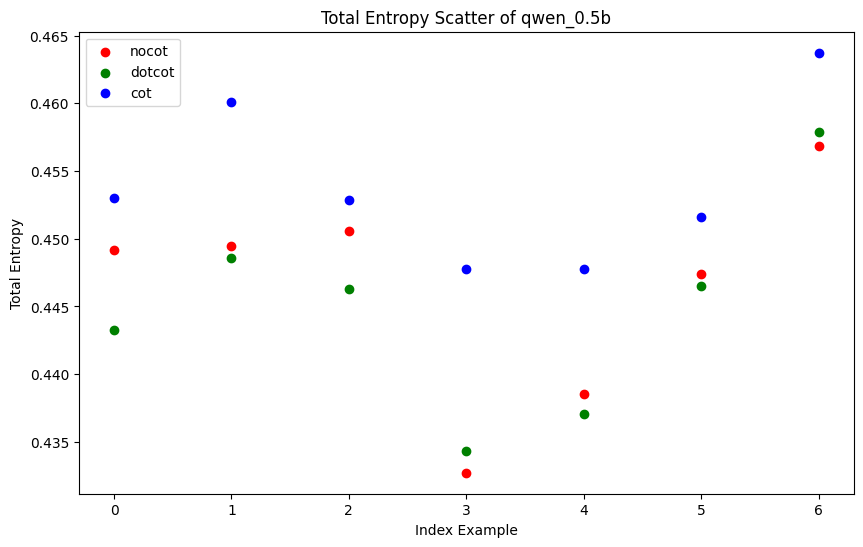

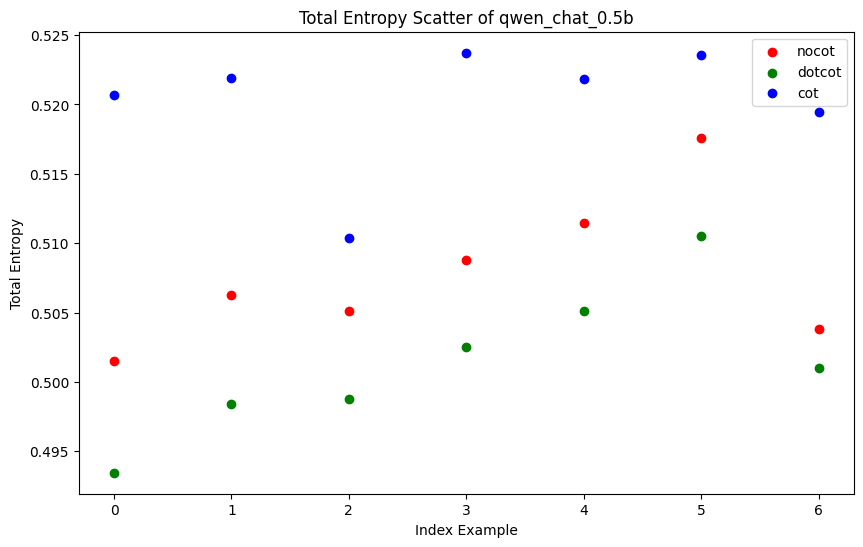

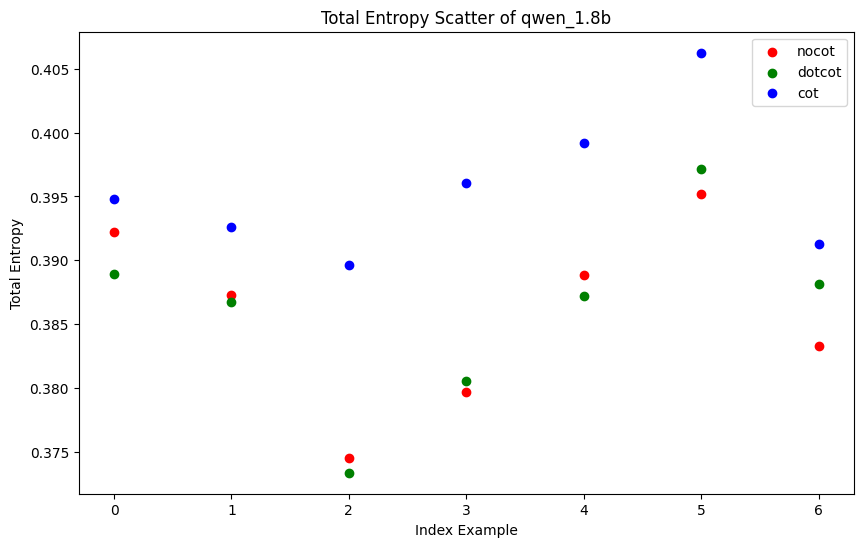

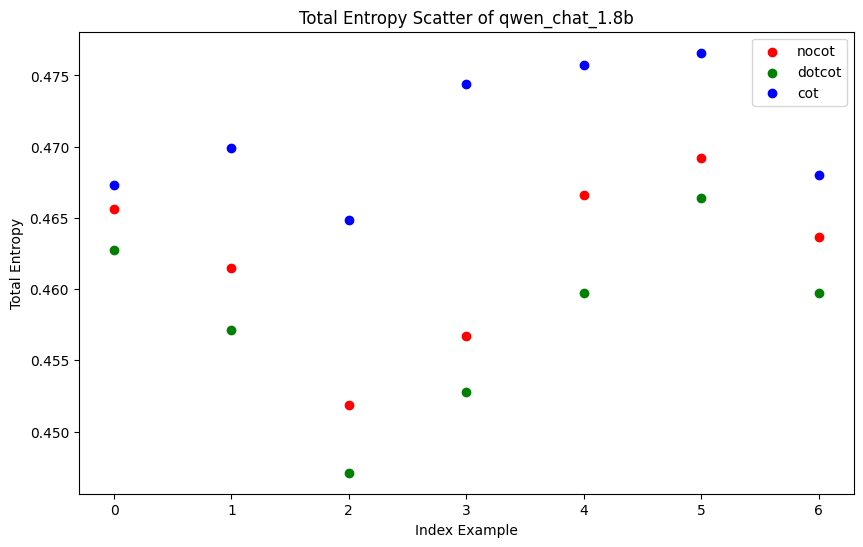

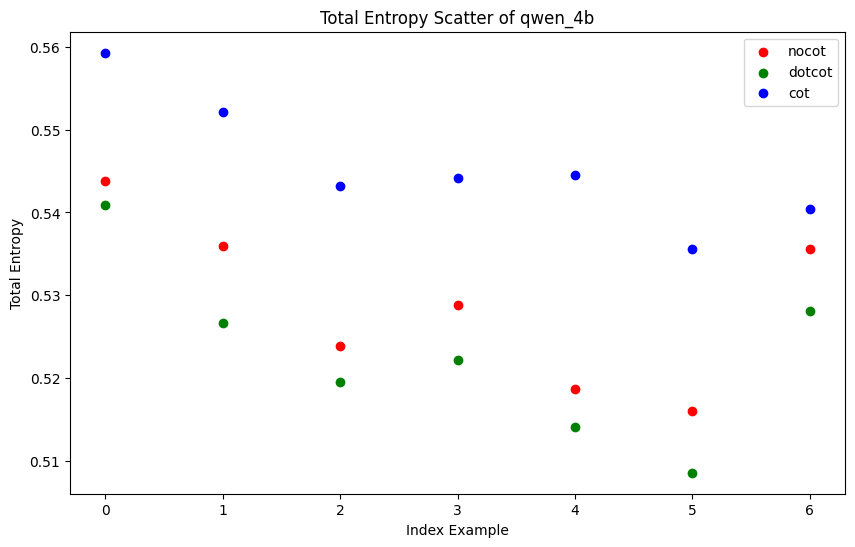

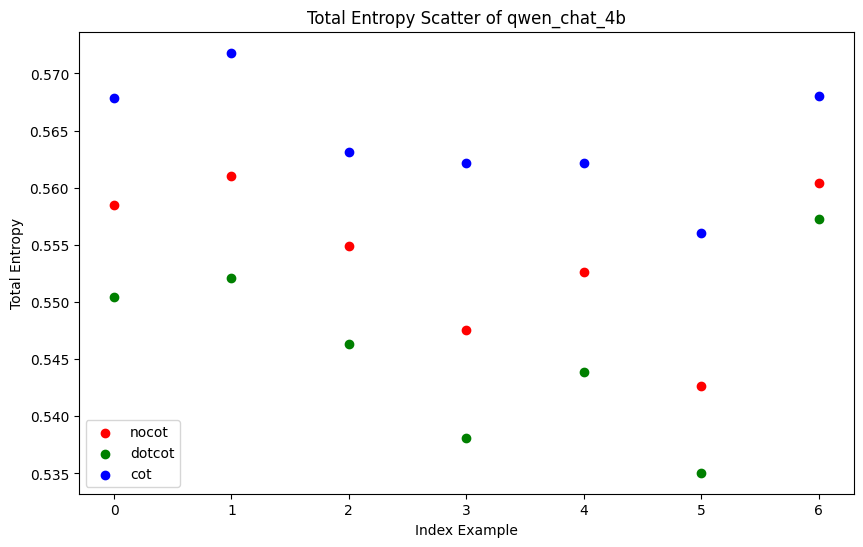

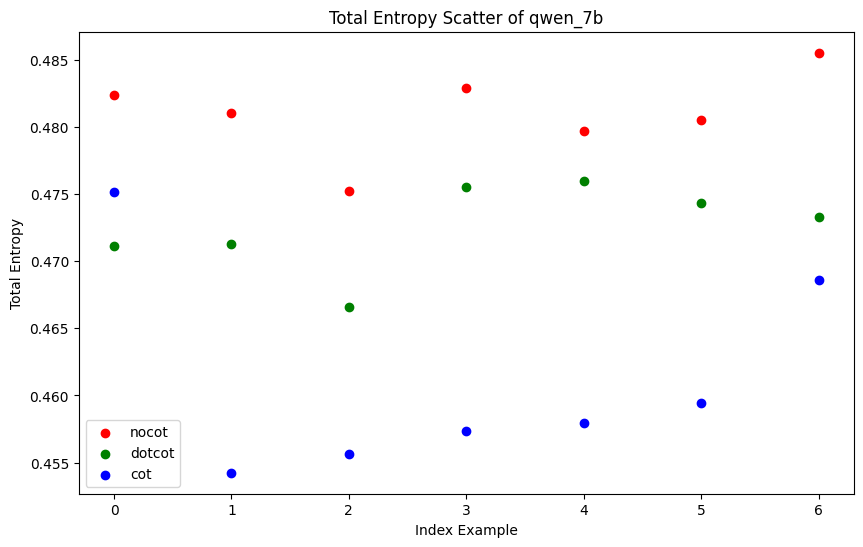

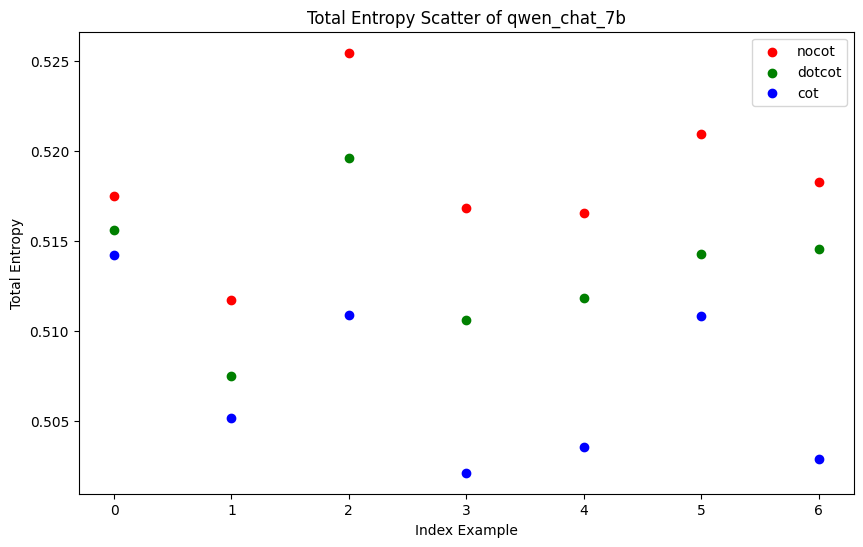

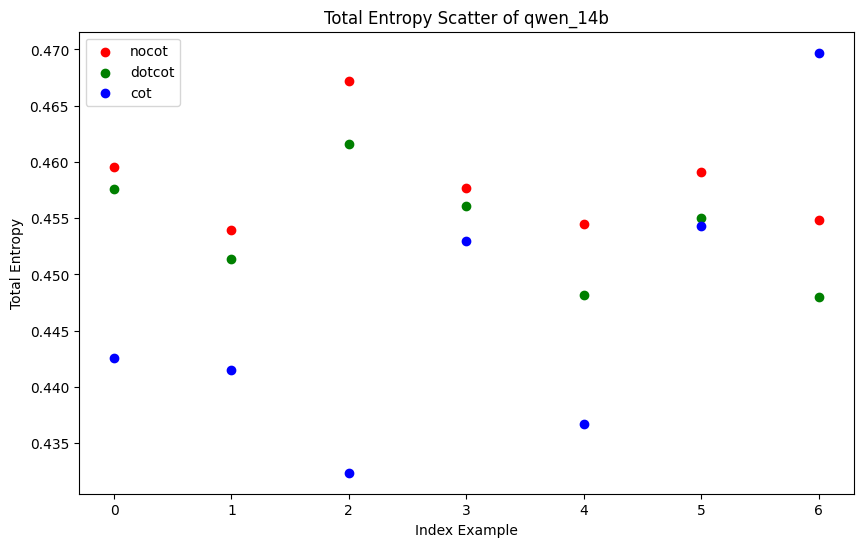

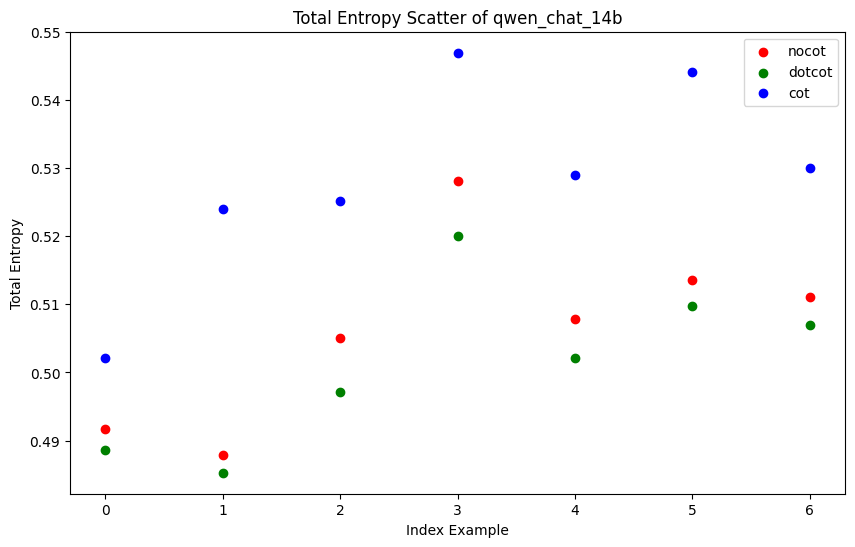

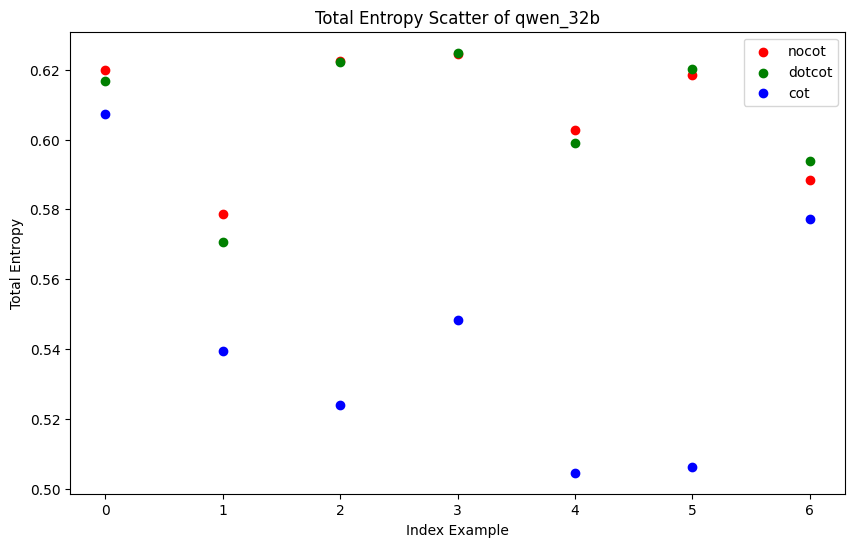

In [16]:
parser = argparse.ArgumentParser()
parser.add_argument("--cfg", default="./config/qwen.yaml", help="config file path")
parser.add_argument("--start", default = 0, type=int, help="config file path")
parser.add_argument("--model_cfg", default="./config/models_pz.yaml", help="model config file path")
# args = parser.parse_args()
args =parser.parse_known_args()[0]

# log_f = '%(asctime)s | %(filename)s[line:%(lineno)d] | %(levelname)s | %(message)s'
# logging.basicConfig(level="DEBUG", format=log_f)
# logging.basicConfig(level="INFO", format=log_f)

# load config 
config = load_config(args.cfg)
model_cfg = load_config(args.model_cfg)

model_familys = config['model_familys']
model_configs = []
for key in model_familys:
    model_configs += model_cfg[f"paths_{key}"]

# models
for model_config in model_configs[args.start:args.start+12]:
    print("model_name:",model_config[0])
    model, tokenizer = load_model_tokenizer(model_config=model_config)

    # data loaders + data processors
    # data_loaders = [getattr(data_loader,loader_name)() for loader_name in config['data_loaders']]
    # data_processors = [getattr(data_processor,processor_name)(model, tokenizer, model_config) for processor_name in config['data_processors']]
    # init pipeline
    data_loaders = [getattr(data_loader,config['data_loaders'][0])()]
    pipeline = Pipeline(model,tokenizer,model_config,data_loaders)
    # run
    pipeline.run()

